# Set-up


In [1]:
import os
import numpy as np
import pandas as pd

import scipy
import scipy.io
import scipy.stats as stats
import pywt

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
!python --version
print(scipy.version.version)

Python 3.8.5
1.6.2


# Gathering the pictures

In [3]:
def get_data_from_Drive(path_to_data_folder):
  from google.colab import drive
  drive.mount('/content/drive')
  return get_data_from_folder(os.path.join("/content/drive/MyDrive", path_to_data_folder))  

def get_data_from_folder( path_to_data_folder ):
  #Each class must recide in its own folder.
  #Returns data as (image as nparray, class)
  #gathering classes
  class_titles = os.listdir(path_to_data_folder)
  classes_list = list( ( enumerate( class_titles ) ) )
  ordered_image_names = []
  #placing image, class identifier (from classes_list) pairs in a list named data
  data = []
  number_of_images = 0
  errors = 0 
  for gyro_class in classes_list:
    for image_name in os.listdir( os.path.join( path_to_data_folder, gyro_class[1] ) ):
      number_of_images+=1
      try:
        im = Image.open( os.path.join( path_to_data_folder, gyro_class[1] , image_name)  )
        color_image_nparray = np.asarray( im )
        data.append( [color_image_nparray, gyro_class[0]] )
        ordered_image_names.append(image_name)
      except Exception as error :
        errors+=1
        print( error, image_name)

  return data, class_titles, ordered_image_names, ( number_of_images, errors )



# Wavelet Decomposition and Flattening


In [4]:
def get_coefficients_flattend( image, wavelet, levels ):
  #image as nparray with color
  #flattens and groups coefficients by orientation and subband
  #returns as  ( cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)  )
  #                                 . 
  #                                 .     
  #                                 . 
  #for each picture
  #n is the level of decomposition
  
  pil_image = Image.fromarray(image, "RGB")
  pil_gray_image = pil_image.convert("L")
  gray_img = np.asarray( pil_gray_image ) 
  decomposed = pywt.wavedec2( gray_img , wavelet, level=levels)

  coeff=[]
  for subband in range(levels+1):
    if subband==0:
      coeff.append(np.asarray(decomposed[subband]).flatten())
      continue
    orientations=[]
    for orientation in decomposed[subband]:
      orientations.append( np.asarray(orientation).flatten() )
    coeff.append(orientations)    

  return coeff

def data_to_coeffs(data, wavelet, levels):
  #calculates wavelet coefficients and flattens them for
  #all of the pictures
  #returns 2D-array (coeffs, class)
  toReturn=[]
  for image, class_id in data:
      instance = get_coefficients_flattend(image, wavelet, levels), class_id
      toReturn.append(instance)
  return toReturn

# Qqplots to visualy check goodness of fit with different distributions

In [5]:
def qqplots_of_image(image, wavelet, levels, dist):
  #image as nparray with color
  coeffs=get_coefficients_flattend(image, wavelet, levels)
  alpha=0.2

  fig,axes = plt.subplots(levels+1,3,figsize=(20,20), constrained_layout=True)
  
  #Progress
  print(getattr(dist,"name"), end=": ")
  for m in range(levels+1):
    if m==0:
      sm.qqplot(coeffs[0], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][0])
      axes[levels-m][0].set_title("Approximation")
      axes[levels-m][0].tick_params(direction="in")
      axes[levels-m][1].remove()
      axes[levels-m][2].remove()
      continue
    for i in range(3):
      if i==0: title="Level "+str(levels-m+1)+": Horizontal"
      if i==1: title="Level "+str(levels-m+1)+": Vertical"
      if i==2: title="Level "+str(levels-m+1)+": Diagonal"

      sm.qqplot(coeffs[m][i], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][i])
      axes[levels-m][i].set_title(title)
      axes[levels-m][i].tick_params(direction="in")

      #Progress
      print(levels-m+1,i,sep="", end=" ")
  print("")
  
  title="qqplots wavelet={} levels={} dist={}".format(wavelet, levels, getattr(dist,"name"))
  fig.suptitle(title, fontsize=16)
  fig.savefig(title)

  return

# Fitting coefficients with matlab

In [6]:
import h5py
import hdf5storage
import numpy as np

def save_coeffs_for_matlab(data, wavelet, levels, save_folder_path):

    all_coeffs = data_to_coeffs(data, wavelet, levels)
    toSave ={"wavelet":wavelet,\
             "levels":levels,\
             "coeffs":np.array(all_coeffs) }

    scipy.io.savemat(os.path.join(save_folder_path ,"coefficients wt="+wavelet+"levels="+str(levels)+".mat"), toSave)
    return


def save_coeffs_for_matlab_hdf5(data, wavelet, levels, save_folder_path):

    all_coeffs = data_to_coeffs(data, wavelet, levels)
    toSave ={"wavelet":wavelet,\
             "levels":levels,\
             "coeffs":np.array(all_coeffs, dtype=object) }
    
    hdf5storage.write(toSave, '.', "coefficients wt="+wavelet+"levels="+str(levels)+"_hdf5 TEST object.mat", matlab_compatible=True)    
    
    return


def load_distribution_parameters_from_matlab(distribution_parameters_path):
    #after fitting on matlab
    load_dict = scipy.io.loadmat(distribution_parameters_path)

    return load_dict


# Loading fit parameters from matlab and preparing them to be used as features with sklearn

In [7]:
def prepare_features_for_scikit(dist_params_select_path):\
  #dist_params_Select is needed to save time by not fitting 
  #distributions to all subbands
  #dist_params_select_path: path to dist_paramsSelect      
    load_dict= load_distribution_parameters_from_matlab(dist_params_select_path)
    
    dist_params = load_dict["dist_params"]
    levels      = load_dict["levels"].reshape(-1)[0]
    wavelet     = load_dict["wavelet"]
    selection   = load_dict["selection"]
    print(selection)
    features=[]
    labels=[]
    column_names=[]
    for instance_index in range(dist_params.shape[0]):
        features_from_instance=[]

        for level_index in range(dist_params[instance_index,0].shape[1]):
            a=level_index==0
            b=([0, 0] in selection.tolist())

            if a&b:
                for parameter_index in range(dist_params[instance_index,0][0,0][0,:].shape[0]):
                    features_from_instance.append(dist_params[instance_index,0][0,0][0, parameter_index])
                    
                    if instance_index==0:
                        column_name = "".join(str(a) for a in ["Approximation", " Parameter ", parameter_index+1])
                        column_names.append(column_name)
                continue

            for orientation in range(3):
                if [levels-level_index+1, orientation+1] in selection.tolist():
                    for parameter_index in range(dist_params[instance_index,0][0,level_index][0,:].shape[0]):
                        features_from_instance.append(dist_params[instance_index,0][0,level_index][orientation, parameter_index])
                        #creating column name
                        if instance_index==0:
                            column_name="".join(str(a) for a in ["Level ",\
                                                                 levels-level_index+1,\
                                                                 " Orientation ",\
                                                                 orientation+1,\
                                                                 " Parameter ",\
                                                                 parameter_index+1])
                            column_names.append(column_name)

        features.append(features_from_instance)
        labels.append(dist_params[instance_index,1].reshape(-1)[0])
    
    #dataframe set up
    df = pd.DataFrame(features, columns=column_names)
    df["Labels"] = labels
        
    return df




# Visualising features

In [8]:
def class_plot_from_distribution_parameters(distribution_parameters_path,\
                                            save_folder_path,\
                                            data_path="D:\\Work and uni\\University\\ML for food authentication\\Data"):
  #dist_params from matlab  
    
  _ , class_titles, _, _= get_data_from_folder(data_path)
  load_dict = load_distribution_parameters_from_matlab(distribution_parameters_path)
  dist_params = load_dict["dist_params"]
  levels = load_dict["levels"][0][0]
  wavelet = load_dict["wavelet"][0]
  distribution = load_dict["distribution"][0]
    
  fig, ax = plt.subplots(figsize=(10,10))
  title="Plot of distribution parameters for\nWavelet "+wavelet+" | Levels: "+str(levels)+" | Distribution: "+ distribution
    
  N=len(class_titles)
  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]
  cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
  bounds = np.linspace(0,N,N+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
  for instance, label in dist_params:
      for level in np.reshape(instance, -1):
          for orientation in level:
              scat = ax.scatter(orientation[0], orientation[1], c=np.reshape(label,-1)[0], s=50, alpha=1, cmap=cmap, norm=norm)
  ax.set_title(title)
    
  ax.set_xlabel("Ditribution Parameter 1")
  ax.set_ylabel("Ditribution Parameter 2")
  ax.tick_params(direction="in")
  cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
  cb.set_label("Classes")
    
  fig.savefig(os.path.join(save_folder_path, "wt= "+wavelet+" levels= "+str(levels)+" dist="+load_dict["distribution"][0]+".jpeg"), dpi=200)
   
  return

# Choosing and Balancing Classes

In [10]:
#randomly chooses images of the larger class to balance out dataset
def balance_classes(n_most_populated_classes):
  class_population = n_most_populated_classes['Labels'].value_counts(sort=True)
  smallest_class_population = class_population.iloc[class_population.shape[0]-1]
    
  balanced_classes = pd.DataFrame()
    
  for i in range(class_population.shape[0]):
      to_append = n_most_populated_classes[n_most_populated_classes["Labels"]==class_population.index[i]].sample(smallest_class_population)
      balanced_classes = balanced_classes.append(to_append, ignore_index=True)

  return balanced_classes

#keeps  n most populated classes
def get_larger_classes(dist_paramsSelect_folder, dist_paramsSelect_name, n):
    #ready dataframe
    dist_paramsSelect_folder_path = dist_paramsSelect_folder
    dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)

    df = prepare_features_for_scikit(dist_paramsSelect_path)
    class_population=df['Labels'].value_counts(sort=True)

    #keeping n most populated classes
    class_population=df['Labels'].value_counts(sort=True)
    n_most_populated_classes= pd.DataFrame()
    
    for i in range(n):
        n_most_populated_classes = n_most_populated_classes.append(df[df["Labels"]==class_population.index[i]])
        
    return n_most_populated_classes, df

# Fitting SVM classifier

In [13]:
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#cross-validate n most populated classes
def balance_and_cv(n_most_populated_classes, cv_split):
    A=balance_classes(n_most_populated_classes).to_numpy()
    x=A[:,:-1]
    y=A[:,-1]

    model=pipeline.Pipeline((\
                             ("scaler",StandardScaler() ),\
                             ("svm_clf", svm.SVC(kernel='rbf', gamma=0.01, C=1, decision_function_shape='ovo'))\
                            ))

    scores = cross_val_score(model, x, y, cv=cv_split)
    return scores


# Testing - Using

In [63]:
data , class_titles, ordered_image_names, results= get_data_from_folder("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\")
print("RESULTS\n",results,"\n==========================")
print("CLASS,titles\n",class_titles,"\n===========================")

cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif
RESULTS
 (258, 3) 
CLASS,titles
 ['castanea 2_pio synithismeni morfi', 'castanea sp', 'cichorium intubus pollen x 400', 'citrus sp', 'eukalyptus sp', 'hedera helix', 'helianthus', 'heliotropium', 'hibiscous', 'inula spinoza', 'origanum', 'pinus', 'reiki_calluna vulgaris_020421', 'sonchus', 'thymus capitatus_020421', 'thymus sp pollen 20-01-21', 'tribulus sp'] 


In [65]:
class_list = list( ( enumerate( class_titles ) ) )
print(class_list)

[(0, 'castanea 2_pio synithismeni morfi'), (1, 'castanea sp'), (2, 'cichorium intubus pollen x 400'), (3, 'citrus sp'), (4, 'eukalyptus sp'), (5, 'hedera helix'), (6, 'helianthus'), (7, 'heliotropium'), (8, 'hibiscous'), (9, 'inula spinoza'), (10, 'origanum'), (11, 'pinus'), (12, 'reiki_calluna vulgaris_020421'), (13, 'sonchus'), (14, 'thymus capitatus_020421'), (15, 'thymus sp pollen 20-01-21'), (16, 'tribulus sp')]


In [ ]:
#wavevelet_decomposition, producing coefficients
wavelets = ["db4"]
levels_list = [3]
save_folder_path="E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\coefficients\\New Images"
for wavelet in wavelets:
    for levels in levels_list:
        save_coeffs_for_matlab(data, wavelet, levels, save_folder_path)
#now run matlab code

In [21]:
#wavevelet_decomposition, producing coefficients hdf5
wavelets = ["db4"]
levels_list = [3]
save_folder_path="F:\\"
for wavelet in wavelets:
    for levels in levels_list:
        save_coeffs_for_matlab_hdf5(data, wavelet, levels, save_folder_path)
#now run matlab code



In [12]:
#checking dist_params_select
dist_paramsSelect_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\"
dist_paramsSelect_name="dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat"
dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)

df = prepare_features_for_scikit(dist_paramsSelect_path)
df

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]


,Level 3 Orientation 1 Parameter 1,Level 3 Orientation 1 Parameter 2,Level 3 Orientation 1 Parameter 3,Level 3 Orientation 2 Parameter 1,Level 3 Orientation 2 Parameter 2,Level 3 Orientation 2 Parameter 3,Level 3 Orientation 3 Parameter 1,Level 3 Orientation 3 Parameter 2,Level 3 Orientation 3 Parameter 3,Level 2 Orientation 1 Parameter 1,...,Level 1 Orientation 1 Parameter 1,Level 1 Orientation 1 Parameter 2,Level 1 Orientation 1 Parameter 3,Level 1 Orientation 2 Parameter 1,Level 1 Orientation 2 Parameter 2,Level 1 Orientation 2 Parameter 3,Level 1 Orientation 3 Parameter 1,Level 1 Orientation 3 Parameter 2,Level 1 Orientation 3 Parameter 3,Labels
0,0.015499,12.458307,1.594933,-0.022699,12.292057,1.670058,0.008295,5.543676,1.664550,0.027276,...,0.018281,0.625013,3.485158,0.017163,0.654109,3.785260,0.231982,0.405976,1.011785e+02,0
1,-0.046184,13.846198,1.828225,0.044203,13.767748,1.880344,-0.023888,6.189891,1.842429,0.035214,...,0.019250,0.633017,3.515816,0.019360,0.662208,3.884462,0.232509,0.405156,9.732472e+01,0
2,-0.464127,10.332537,1.722098,-0.260163,9.507803,1.662098,0.004879,3.319890,1.932577,-0.004514,...,0.017996,0.566219,9.484882,0.018083,0.593911,9.398936,0.239219,0.405006,1.184996e+02,1
3,-0.012934,4.024722,0.647543,0.009320,3.991315,0.652696,0.010327,2.623836,0.971317,0.006228,...,0.018160,0.579416,3.412910,0.020209,0.626922,4.143669,0.230042,0.399771,4.647807e+01,1
4,-0.328682,6.205700,1.294496,-0.268832,6.458088,1.340303,0.003031,2.648695,1.856746,-0.005134,...,0.016781,0.541915,8.344530,0.015809,0.584378,9.642145,0.238482,0.403939,1.798100e+02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.000207,2.216200,1.710630,-0.001537,2.239670,1.634291,0.005483,1.744878,2.446782,0.010841,...,0.017047,0.512381,12.967385,0.016123,0.556792,11.733031,0.275255,0.371646,2.935916e+06,15
251,0.001991,2.176240,1.651137,0.015628,2.221495,1.696624,0.009473,1.760879,2.489069,0.007204,...,0.017682,0.515770,12.121050,0.017411,0.570847,18.347133,0.275307,0.371907,7.623106e+05,15
252,-0.011454,1.868111,2.557919,0.004109,1.923493,2.732035,0.001296,1.608726,3.857855,0.007968,...,0.017880,0.524897,28.953561,0.018373,0.579815,47.517008,0.275609,0.372207,2.810986e+06,15
253,-0.012554,1.939313,2.210927,0.011734,1.966064,2.159067,0.000689,1.662151,3.687046,0.010530,...,0.017611,0.518739,21.500342,0.017953,0.571778,27.934737,0.274741,0.371831,1.370401e+06,15


cannot identify image file 'D:\\Work and uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'D:\\Work and uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'D:\\Work and uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif


'for dist_params_name in  os.listdir( dist_params_folder_path ):\n    print(dist_params_name)\n    dist_params_path=os.path.join(dist_params_folder_path, dist_params_name)\n    class_plot_from_distribution_parameters(dist_params_path, save_folder_path)\n\n'

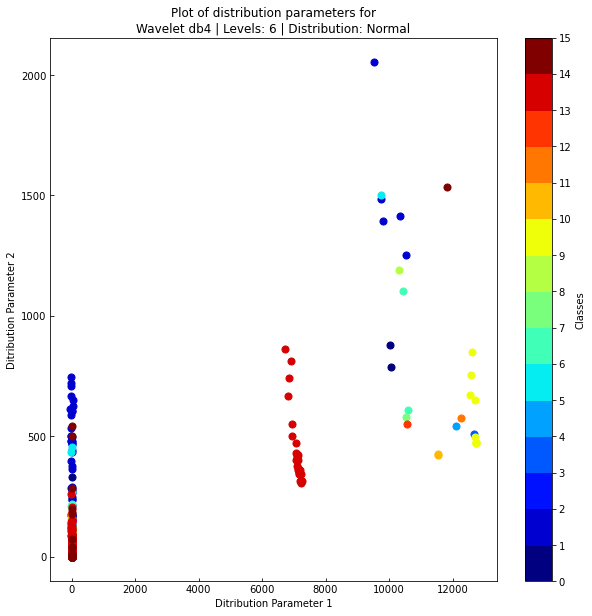

In [35]:
#single Class Plot
dist_params_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_params\\"
save_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\Class Plots\\"
dist_params_name="dist_params wt=db4 levels=6 dist=Normal.mat"
dist_params_path=os.path.join(dist_params_folder_path, dist_params_name)

class_plot_from_distribution_parameters(dist_params_path, save_folder_path)

#all available dist_params Plots
"""for dist_params_name in  os.listdir( dist_params_folder_path ):
    print(dist_params_name)
    dist_params_path=os.path.join(dist_params_folder_path, dist_params_name)
    class_plot_from_distribution_parameters(dist_params_path, save_folder_path)

"""


# Visualisation of wavelet decomposition

In [15]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import statsmodels.api as sm
import scipy.stats as stats


n=3
im = Image.open("D:\\Work and uni\\University\\ML for food authentication\\Data\\origanum\\origanum.tif")
plt.imshow(np.asarray(im))
plt

gray_img = im.convert("L")
plt.figure()
plt.imshow(np.asarray(gray_img), cmap=plt.get_cmap('gray'))
gray_array = np.asarray(gray_img)

C = pywt.wavedec2( gray_array , 'db1', level=n)

C[0] /= np.abs(C[0]).max()
for m in range(n):
  if m==0:
    continue
  for mat in C[m]:
    mat /= np.abs(mat).max()

arr , slices = pywt.coeffs_to_array(C)

plt.figure(figsize=[12,12])
plt.imshow(arr, cmap=plt.get_cmap('gray'), vmin=-0.25, vmax=0.75 )
plt.savefig("hooray.jpeg")

a=[1,2,['name', im]]
plt.figure()
plt.imshow(np.asarray(a[2][1]))

TypeError: object of type 'TiffImageFile' has no len()

# Balancing classes and cross validating SVM


In [13]:
#2 balanced classes wt=db4 levels=5 dist=Stable
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\" ,\
                                        "dist_paramsSelect wt=db4 levels=5 dist=Stable.mat",\
                                        2)
for i in range(20):
    scores=balance_and_cv(larger_classes, 3)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


[[5 1]
 [5 2]
 [5 3]
 [0 0]]
       Mean Accuracy  Standard Deviation
count      20.000000           20.000000
mean        0.937222            0.075531
std         0.074254            0.085071
min         0.755556            0.000000
25%         0.883333            0.000000
50%         0.944444            0.078567
75%         1.000000            0.109994
max         1.000000            0.282843


,Mean Accuracy,Standard Deviation
0,1.000000,0.000000
1,0.866667,0.188562
2,0.944444,0.078567
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,0.888889,0.157135
8,0.933333,0.094281
9,1.000000,0.000000


In [14]:
#2 balanced classes wt=db4 levels=3 dist=Stable
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist=Stable.mat",\
                                        2)
for i in range(20):
    scores=balance_and_cv(larger_classes, 3)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count      20.000000           20.000000
mean        0.996667            0.004714
std         0.014907            0.021082
min         0.933333            0.000000
25%         1.000000            0.000000
50%         1.000000            0.000000
75%         1.000000            0.000000
max         1.000000            0.094281


,Mean Accuracy,Standard Deviation
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.933333,0.094281
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


In [16]:
#2 balanced classes wt=db4 levels=3 dist=tLocationScale
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat",\
                                        2)
for i in range(20):
    scores=balance_and_cv(larger_classes, 3)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count           20.0                20.0
mean             1.0                 0.0
std              0.0                 0.0
min              1.0                 0.0
25%              1.0                 0.0
50%              1.0                 0.0
75%              1.0                 0.0
max              1.0                 0.0


,Mean Accuracy,Standard Deviation
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [57]:
#class populations
dist_paramsSelect_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\"    
dist_paramsSelect_name = "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat"
dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)
df = prepare_features_for_scikit(dist_paramsSelect_path)

class_population=df['Labels'].value_counts(sort=True)
class_population

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]


13    26
9      8
1      5
10     2
6      2
0      2
14     1
12     1
11     1
8      1
7      1
5      1
4      1
3      1
Name: Labels, dtype: int64

In [58]:
#3 most populated classes wt=db4 levels=3 tLocScale
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat", 3)
for i in range(20):
    scores=balance_and_cv(larger_classes)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results



[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count      20.000000           20.000000
mean        0.986667            0.018856
std         0.027359            0.038692
min         0.933333            0.000000
25%         1.000000            0.000000
50%         1.000000            0.000000
75%         1.000000            0.000000
max         1.000000            0.094281


,Mean Accuracy,Standard Deviation
0,0.933333,0.094281
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


In [23]:
#3 most populated classes Stable
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("dist_paramsSelect wt=db4 levels=3 dist=Stable.mat", 3)
for i in range(20):
    scores=balance_and_cv(larger_classes)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)

print(results.describe())
results


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count      50.000000           50.000000
mean        0.948000            0.048891
std         0.066380            0.056431
min         0.800000            0.000000
25%         0.933333            0.000000
50%         1.000000            0.000000
75%         1.000000            0.094281
max         1.000000            0.163299


,Mean Accuracy,Standard Deviation
0,1.000000,0.000000
1,0.866667,0.094281
2,0.933333,0.094281
3,0.800000,0.163299
4,0.866667,0.094281
5,0.933333,0.094281
6,1.000000,0.000000
7,0.933333,0.094281
8,1.000000,0.000000
9,1.000000,0.000000


In [24]:
#3 most populated classes wt=db4 levels=3 Normal
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("dist_paramsSelect wt=db4 levels=3 dist=Normal.mat", 3)
for i in range(50):
    scores=balance_and_cv(larger_classes)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)

print(results.describe())
results

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count      50.000000        5.000000e+01
mean        0.685333        2.241588e-01
std         0.075039        8.009041e-02
min         0.600000        1.110223e-16
25%         0.600000        1.885618e-01
50%         0.666667        2.494438e-01
75%         0.733333        2.828427e-01
max         0.866667        3.771236e-01


,Mean Accuracy,Standard Deviation
0,0.800000,1.110223e-16
1,0.666667,2.494438e-01
2,0.600000,3.265986e-01
3,0.666667,1.885618e-01
4,0.866667,9.428090e-02
5,0.600000,3.265986e-01
6,0.600000,3.265986e-01
7,0.666667,2.494438e-01
8,0.600000,2.828427e-01
9,0.733333,1.885618e-01


In [61]:
#NEW IMAGES

#class populations
dist_paramsSelect_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\"    
dist_paramsSelect_name = "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat"
dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)
df = prepare_features_for_scikit(dist_paramsSelect_path)

class_population=df['Labels'].value_counts(sort=True)
print("\nClass ID, # of instances")
print(class_population)

#To keep all results
all_results = pd.DataFrame(columns=["# of Classes", "# of instances", "Distribution", "Wavelet", "Levels", "# of runs", "CV split" ,"Mean Accuracy", "Standard Deviation of Mean Accuracy",])

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]

Class ID, # of instances
12    101
14    101
15     26
9       8
1       5
0       2
6       2
10      2
3       1
4       1
5       1
7       1
8       1
11      1
13      1
16      1
Name: Labels, dtype: int64


In [18]:
#2 most populated classes wt=db4 levels=3 Normal
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat", \
                                        2)
for i in range(100):
    scores=balance_and_cv(larger_classes, 20)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results



[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count     100.000000          100.000000
mean        0.975168            0.047883
std         0.002831            0.007368
min         0.970000            0.038236
25%         0.975000            0.042553
50%         0.975000            0.043301
75%         0.975455            0.053619
max         0.980909            0.071414


,Mean Accuracy,Standard Deviation
0,0.975455,0.042553
1,0.975909,0.052403
2,0.970455,0.045170
3,0.975909,0.041786
4,0.976364,0.050074
...,...,...
95,0.975000,0.043301
96,0.975455,0.042553
97,0.980000,0.040000
98,0.970000,0.055678


In [19]:
#2 most populated classes wt=db4 levels=3 tLocationScale
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat", \
                                        2)
for i in range(100):
    scores=balance_and_cv(larger_classes, 20)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count     100.000000          100.000000
mean        0.995045            0.021596
std         0.000137            0.000597
min         0.995000            0.019813
25%         0.995000            0.021794
50%         0.995000            0.021794
75%         0.995000            0.021794
max         0.995455            0.021794


,Mean Accuracy,Standard Deviation
0,0.995000,0.021794
1,0.995000,0.021794
2,0.995000,0.021794
3,0.995000,0.021794
4,0.995000,0.021794
...,...,...
95,0.995455,0.019813
96,0.995000,0.021794
97,0.995000,0.021794
98,0.995000,0.021794


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count    1000.000000         1000.000000
mean        0.897998            0.063484
std         0.031141            0.023599
min         0.745000            0.002041
25%         0.883333            0.048419
50%         0.898333            0.063268
75%         0.922500            0.075875
max         0.975000            0.166471


,Mean Accuracy,Standard Deviation
0,0.949167,0.047022
1,0.857500,0.067103
2,0.898333,0.074190
3,0.924167,0.046577
4,0.871667,0.068587
...,...,...
995,0.948333,0.025900
996,0.922500,0.076811
997,0.871667,0.039739
998,0.782500,0.128706


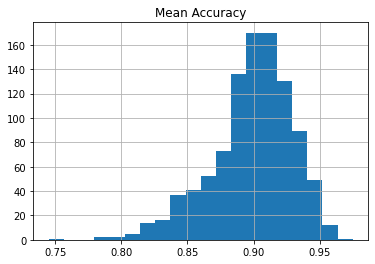

In [69]:
#3 most populated classes wt=db4 levels=3 Normal
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat", \
                                        3)
for i in range(1000):
    scores=balance_and_cv(larger_classes, 5)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results.hist("Mean Accuracy", bins=20)
results

In [47]:
#3 most populated classes wt=db4 levels=3 tLocationScale
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat", \
                                        3)
for i in range(1000):
    scores=balance_and_cv(larger_classes, 5)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count    1000.000000         1000.000000
mean        0.990052            0.017281
std         0.010274            0.015953
min         0.935833            0.000000
25%         0.986667            0.000000
50%         0.987500            0.025000
75%         1.000000            0.026667
max         1.000000            0.080433


,Mean Accuracy,Standard Deviation
0,0.987500,0.025000
1,0.987500,0.025000
2,0.987500,0.025000
3,0.975000,0.050000
4,0.987500,0.025000
...,...,...
995,0.987500,0.025000
996,1.000000,0.000000
997,0.975000,0.050000
998,0.986667,0.026667


In [42]:
#4 most populated classes wt=db4 levels=3 Normal
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat", \
                                        4)
for i in range(1000):
    scores=balance_and_cv(larger_classes, 2)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count    1000.000000         1000.000000
mean        0.650906            0.071243
std         0.062390            0.037752
min         0.406061            0.012856
25%         0.621212            0.038090
50%         0.654545            0.064282
75%         0.687879            0.095443
max         0.812121            0.210644


,Mean Accuracy,Standard Deviation
0,0.657576,0.080060
1,0.530303,0.077258
2,0.654545,0.053526
3,0.596970,0.072853
4,0.687879,0.038090
...,...,...
995,0.593939,0.037360
996,0.500000,0.037113
997,0.593939,0.111423
998,0.684848,0.095443


In [44]:
#4 most populated classes wt=db4 levels=3 tLocationScale
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\", \
                                        "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat", \
                                        4)
for i in range(1000):
    scores=balance_and_cv(larger_classes, 2)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
       Mean Accuracy  Standard Deviation
count    1000.000000         1000.000000
mean        0.888000            0.040375
std         0.050307            0.030001
min         0.718750            0.000000
25%         0.843750            0.031250
50%         0.906250            0.031250
75%         0.914062            0.062500
max         1.000000            0.156250


,Mean Accuracy,Standard Deviation
0,0.71875,0.03125
1,0.87500,0.00000
2,0.93750,0.06250
3,0.93750,0.06250
4,0.93750,0.00000
...,...,...
995,0.93750,0.00000
996,0.90625,0.03125
997,0.96875,0.03125
998,0.90625,0.03125
